In [1]:
using JLD2
using FourierFlows
using FourierFlows: parsevalsum2
using Printf
using CairoMakie
using AbstractFFTs

include("../../rsw/RSWUtils.jl")
include("AnalysisUtils.jl")

mapfilter_snapshots (generic function with 1 method)

In [2]:
function wave_balanced_msw_decomposition(uh, vh, ηh, grid, params)
    qh = 1im * grid.kr .* vh - 1im * grid.l .* uh - params.f * ηh
    ψh = -qh ./ (grid.Krsq .+ params.f^2/params.Cg2)
    ψ = irfft(ψh, grid.nx)
    ugh = -1im * grid.l .* ψh
    vgh = 1im * grid.kr .* ψh
    ηg = @. (1 - 2*f/Cg2*ψ)^(-0.5) - 1
    ηgh = rfft(ηg)
    uwh = uh - ugh
    vwh = vh - vgh
    ηwh = ηh - ηgh
    return ((ugh, vgh, ηgh), (uwh, vwh, ηwh))
end

function msw_cubic_energy(uh, vh, ηh, params)
    u = irfft(uh, grid.nx)
    v = irfft(vh, grid.nx)
    η = Float64.(irfft(ηh, grid.nx))
    #APE = @. 1 / (1 + η) + η
    #root_APE = @. sqrt(APE)
    root_APE = η
    root_APEh = rfft(root_APE)
    mu = @. sqrt(1 + η) * u
    mv = @. sqrt(1 + η) * v
    muh = rfft(mu)
    mvh = rfft(mv)

    return muh, mvh, root_APEh
end

msw_cubic_energy (generic function with 1 method)

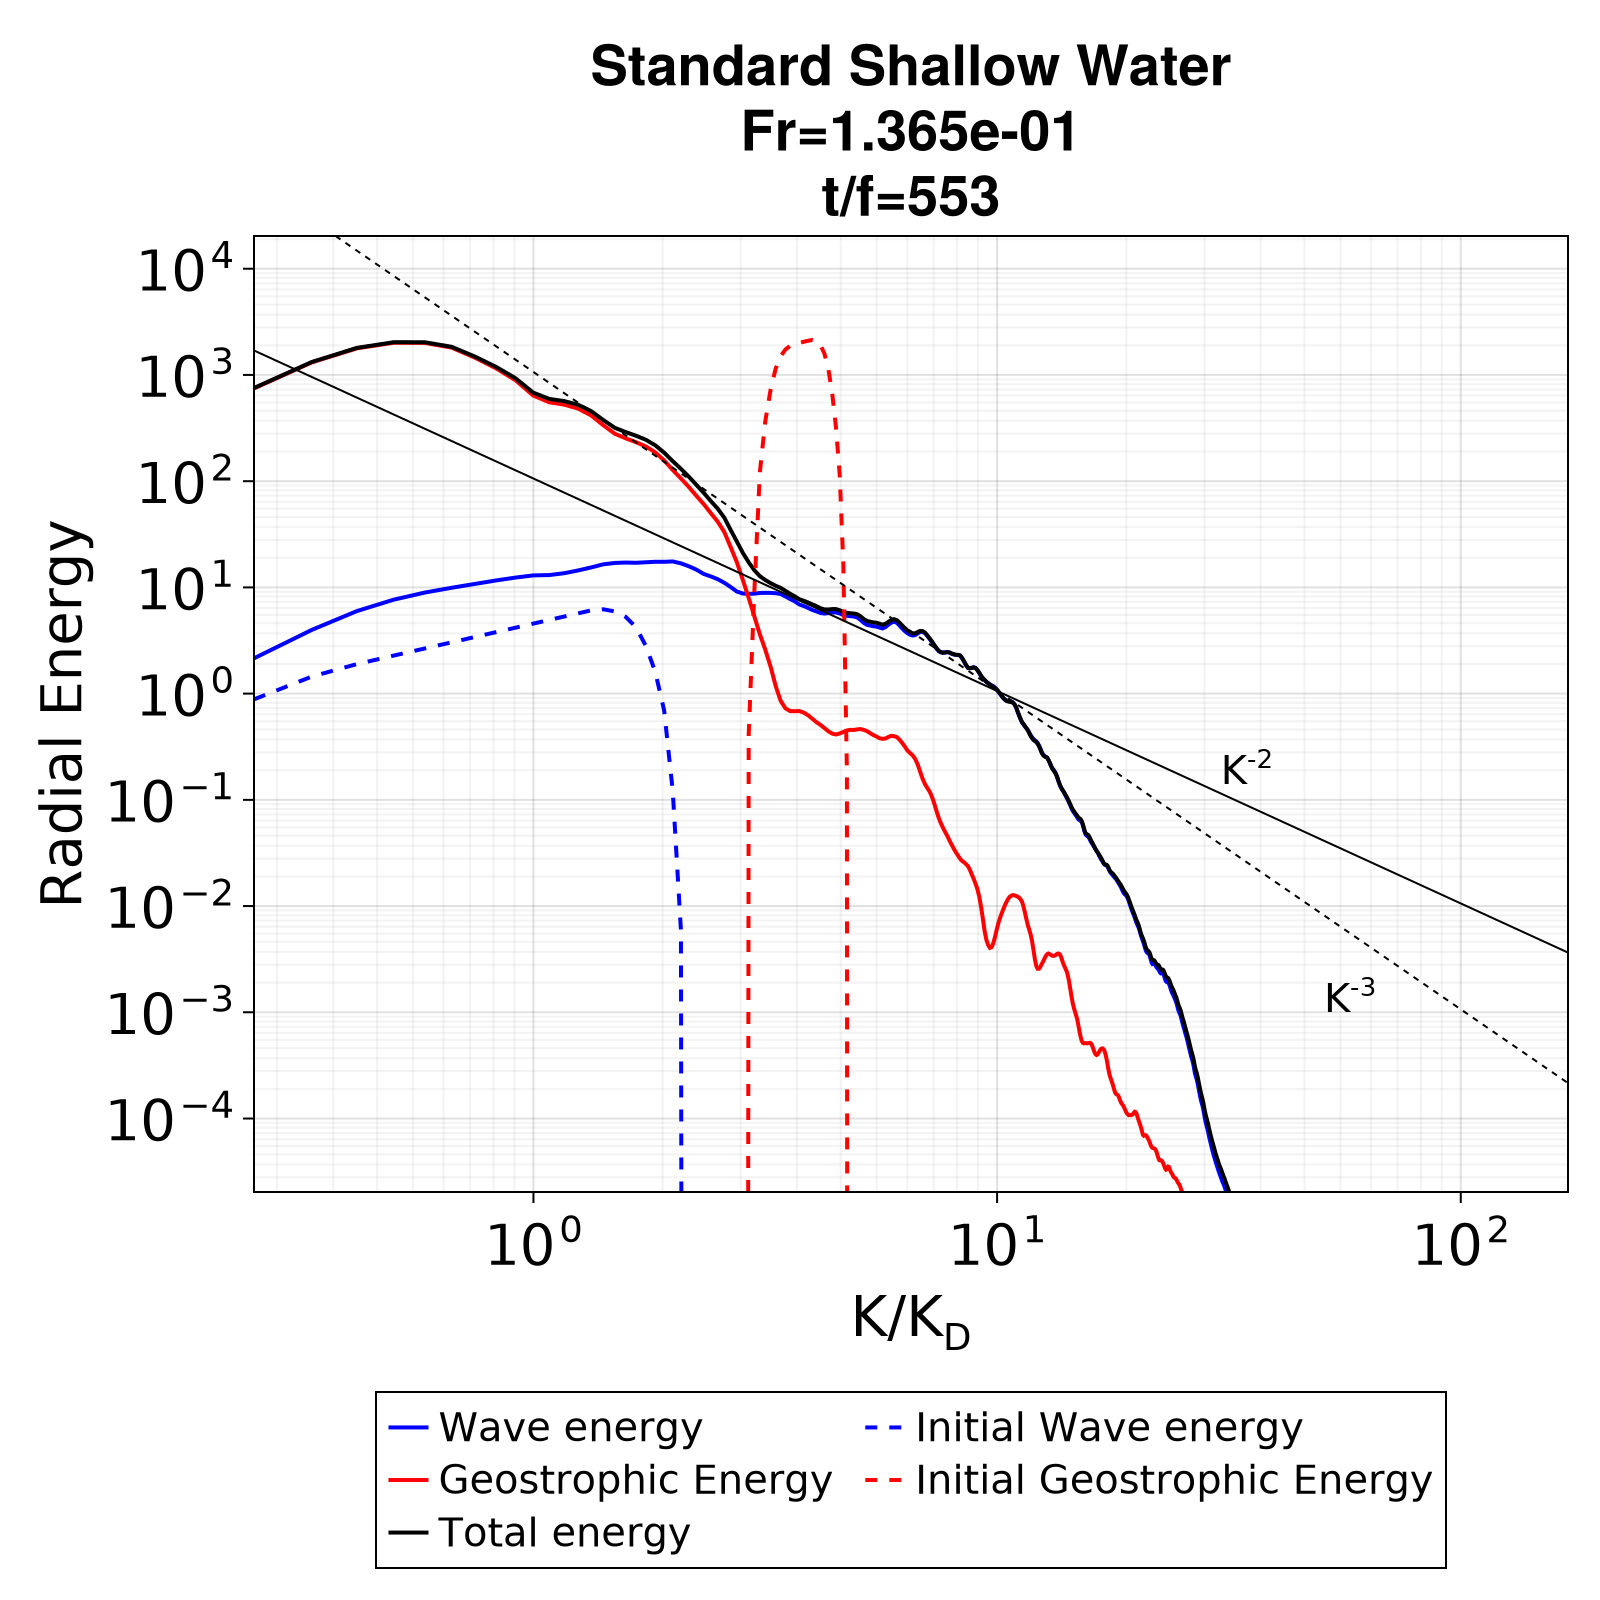

In [6]:
run_directory = "/vast/nad9961/lrsw/3765813/"

#run_directory = "/vast/nad9961/rsw/3631319"
#run_directory = "/vast/nad9961/mrsw/3631316"
#run_directory = "/vast/nad9961/lrsw/3631317"

#run_directory = "/vast/nad9961/rsw/3613076"
#run_directory = "/vast/nad9961/mrsw/3613077"
#run_directory = "/vast/nad9961/mrsw/3464699"
#run_directory = "/vast/nad9961/rsw/3467107"

#run_directory = "/vast/nad9961/rsw/3470996"
#run_directory = "/vast/nad9961/mrsw/3470997"

#run_directory = "/vast/nad9961/lrsw/3467644"
#run_directory = "/vast/nad9961/mrsw/3464699"
#run_directory = "/vast/nad9961/rsw/3467107"

#run_directory = "/vast/nad9961/mrsw/3464699"
#run_directory = "/vast/nad9961/mrsw/3400727"
#run_directory = "/vast/nad9961/rsw/3400726"
#run_directory = "/vast/nad9961/mrsw/3285162"
#run_directory = "/vast/nad9961/rsw/3285164"

nx, Lx = get_grid_size(run_directory, "rsw")
grid = TwoDGrid(; nx, Lx)
f, Cg2 = read_rsw_params(run_directory)
Kd = f/sqrt(Cg2)
ν, nν = read_rsw_dissipation(run_directory)
params = (; f, Cg2, ν, nν)

Nsnaps = count_key_snapshots(run_directory, "rsw")
t0, sol0 = load_key_snapshot(run_directory, "rsw", 1)
u0h = sol0[:,:,1]
v0h = sol0[:,:,2]
η0h = sol0[:,:,3]

t1, sol1 = load_key_snapshot(run_directory, "rsw", Nsnaps)
u1h = sol1[:,:,1]
v1h = sol1[:,:,2]
η1h = sol1[:,:,3]

((u1gh, v1gh, η1gh), (u1wh, v1wh, η1wh)) = wave_balanced_decomposition(u1h, v1h, η1h, grid, params)
#((u0gh, v0gh, η0gh), (u0wh, v0wh, η0wh)) = wave_balanced_decomposition(u0h, v0h, η0h, grid, params)
#((u1gh, v1gh, η1gh), (u1wh, v1wh, η1wh)) = wave_balanced_msw_decomposition(u1h, v1h, η1h, grid, params)
((u0gh, v0gh, η0gh), (u0wh, v0wh, η0wh)) = wave_balanced_decomposition(u0h, v0h, η0h, grid, params)

ug2_total = FourierFlows.parsevalsum2(u1gh, grid) + FourierFlows.parsevalsum2(v1gh, grid)
ug_rms = sqrt.(ug2_total/grid.Lx/grid.Ly)
Fr = ug_rms / sqrt.(Cg2)


mu0gh, mv0gh, mη0gh = msw_cubic_energy(u0gh, v0gh, η0gh, params)
mu0wh, mv0wh, mη0wh = msw_cubic_energy(u0wh, v0wh, η0wh, params)

mu1h,  mv1h,  mη1h  = msw_cubic_energy(u1h,  v1h,  η1h,  params)
mu1gh, mv1gh, mη1gh = msw_cubic_energy(u1gh, v1gh, η1gh, params)
mu1wh, mv1wh, mη1wh = msw_cubic_energy(u1wh, v1wh, η1wh, params)

fig = Figure(; size=(800, 800), fontsize=28, fonts = (; regular = "Dejavu"))
ρ, Ehr0w = FourierFlows.radialspectrum(0.5*(abs2.(u0wh) + abs2.(v0wh) + params.Cg2*abs2.(η0wh)) / grid.nx^2 / grid.Lx, grid)
ρ, Ehr0g = FourierFlows.radialspectrum(0.5*(abs2.(u0gh) + abs2.(v0gh) + params.Cg2*abs2.(η0gh)) / grid.nx^2 / grid.Lx, grid)

ρ, Ehr1  = FourierFlows.radialspectrum(0.5*(abs2.(mu1h)  + abs2.(mv1h)  + params.Cg2*abs2.(mη1h))  / grid.nx^2 / grid.Lx, grid)
ρ, Ehr1g = FourierFlows.radialspectrum(0.5*(abs2.(mu1gh) + abs2.(mv1gh) + params.Cg2*abs2.(mη1gh)) / grid.nx^2 / grid.Lx, grid)
ρ, Ehr1w = FourierFlows.radialspectrum(0.5*(abs2.(mu1wh) + abs2.(mv1wh) + params.Cg2*abs2.(mη1wh)) / grid.nx^2 / grid.Lx, grid)

max_E = max(maximum(Ehr1))
limits = ((3 * ρ[2]/Kd, ρ[end]/Kd), (1e-8 * max_E, 10 * max_E))
ax_opts = (; xscale=log10, yscale=log10, 
        ylabel = "Radial Energy",
        xlabel=rich("K/K",subscript("D")), xticks=LogTicks(WilkinsonTicks(3)), 
        yticks=LogTicks(WilkinsonTicks(7; k_min=4)),
        xminorticks=IntervalsBetween(10),
        xminorgridvisible=true,
        yminorticks=IntervalsBetween(10),
        yminorgridvisible=true,
        limits=limits)
title=@sprintf("Standard Shallow Water\nFr=%0.3e\nt/f=%0.0f", Fr, t1/f)
ax = Axis(fig[1,1]; xscale=log10, yscale=log10, title=title, ax_opts...)


lines!(ax, ρ/Kd, Ehr1w[:]; linewidth=2, color=:blue, label="Wave energy")
lines!(ax, ρ/Kd, Ehr1g[:]; linewidth=2, color=:red, label="Geostrophic Energy")
lines!(ax, ρ/Kd, Ehr1[:]; linewidth=2, color=:black, label="Total energy")
lines!(ax, ρ/Kd, replace(Ehr0w[:], 0.0=>1e-50); linewidth=2, color=:blue, linestyle=:dash, label="Initial Wave energy")
lines!(ax, ρ/Kd, replace(Ehr0g[:], 0.0=>1e-50); linewidth=2, color=:red, linestyle=:dash, label="Initial Geostrophic Energy")

ρ10_idx = findfirst(x -> x >= 10, ρ/f)
E10 = Ehr1[ρ10_idx]
power_2 = E10*(ρ/ρ[ρ10_idx]).^(-2)
power_3 = E10*(ρ/ρ[ρ10_idx]).^(-3)
lines!(ax, ρ/Kd, power_2, color="black", linestyle=:solid, linewidth=1)
lines!(ax, ρ/Kd, power_3, color="black", linestyle=:dash, linewidth=1)

text!(ax,  ρ[3*ρ10_idx]/Kd, power_2[3*ρ10_idx], text=rich("K", superscript("-2")), fontsize=20)
text!(ax, ρ[5*ρ10_idx]/Kd, 0.1*power_3[5*ρ10_idx], text=rich("K", superscript("-3")), fontsize=20)
Legend(fig[2,1], ax, orientation=:horizontal, labelsize=20, nbanks=3)
resize_to_layout!(fig)

if occursin("mrsw", run_directory)
    save("images/modified_shallow_water_radial_spectrum.eps", fig)
elseif occursin("lrsw", run_directory)
    save("images/lindborg_shallow_water_radial_spectrum.eps", fig)
else
    save("images/standard_shallow_water_radial_spectrum.eps", fig)
end

fig

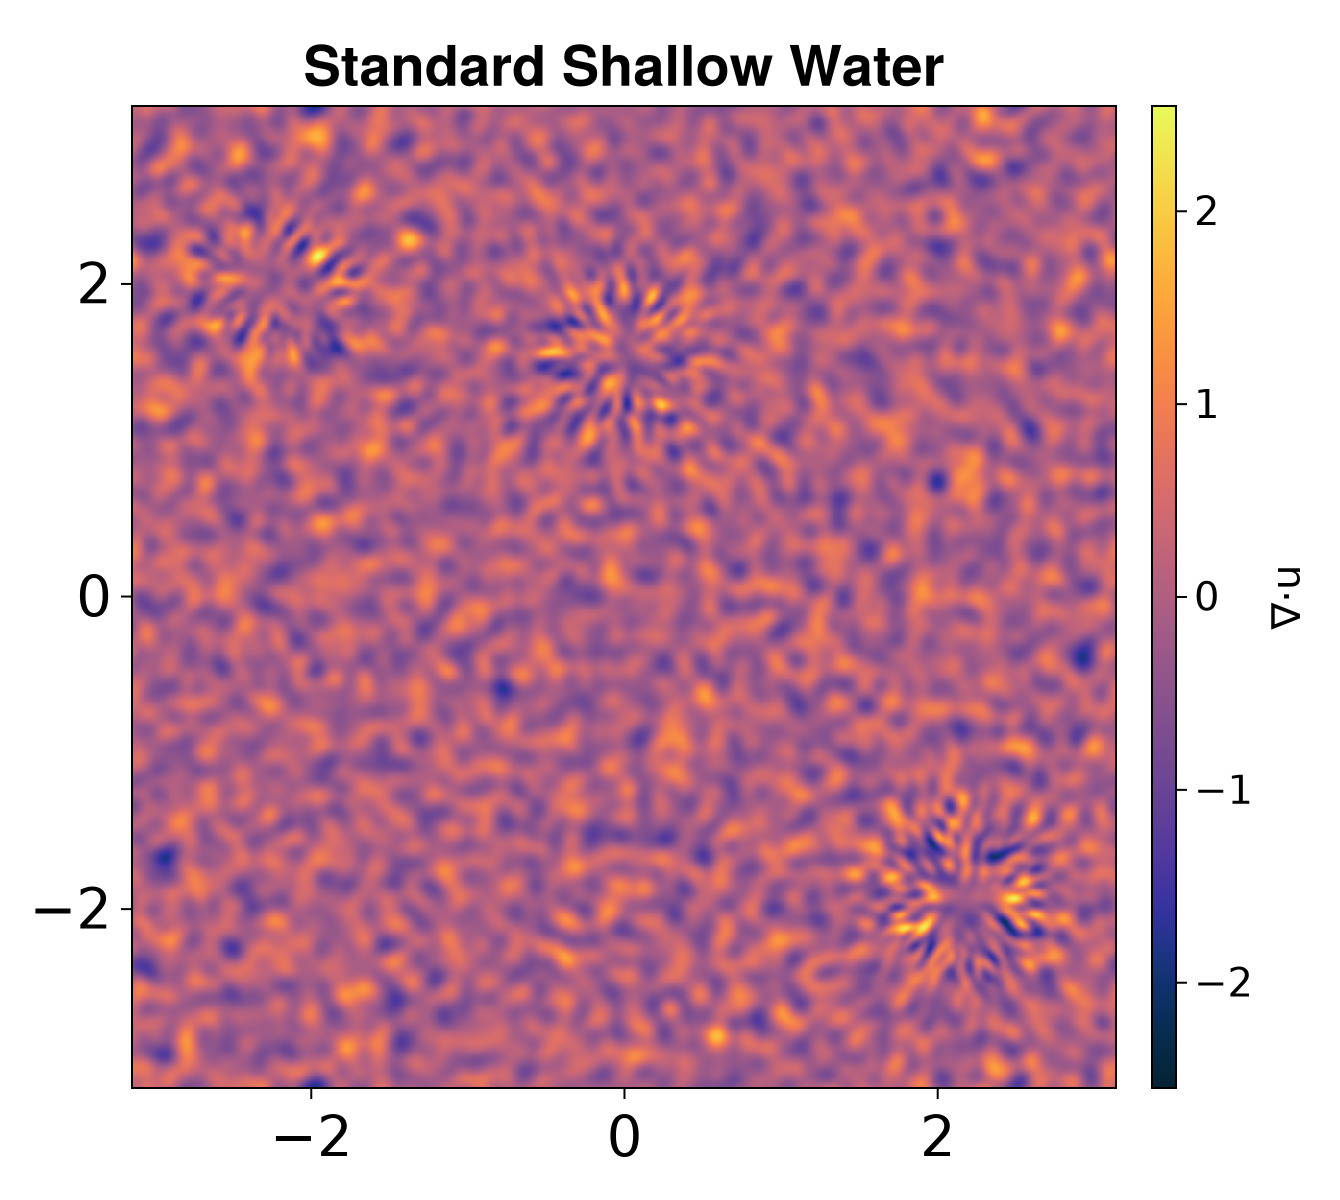

In [7]:
fig = Figure(; size=(600, 600), fontsize=28, fonts = (; regular = "Dejavu"))
divh = 1im * grid.kr .* u1h + 1im * grid.l .* v1h
div = irfft(divh, grid.nx)
divmax = maximum(abs.(div))

ax = Axis(fig[1,1]; title="Standard Shallow Water")
hm = heatmap!(ax, grid.x, grid.y, div, colormap=:thermal, colorrange=(-divmax, divmax))
Colorbar(fig[1,2], hm, label="∇⋅u", labelsize=20, ticklabelsize=20)

colsize!(fig.layout, 1, Aspect(1, 1.0))
resize_to_layout!(fig)

if occursin("mrsw", run_directory)
    save("images/modified_shallow_water_divergence.png", fig)
else 
    save("images/standard_shallow_water_divergence.png", fig)
end
fig